In [1]:
import torch

from Detection.Models import Yolo
from Detection.Metrics.loss import YOLOv1Loss as Loss
from Detection.Metrics import calculate_voc_mAP
from Detection.Utils.yolo_utils import decode_yolo2dict
from Detection.Data.voc import VOC as Dataset
from torch.utils.data import DataLoader
from torchvision.utils import draw_bounding_boxes
from torchvision.transforms import transforms

from Utils import detection_config as cfg
from Utils import optim

import matplotlib.pyplot as plt

from IPython.display import clear_output

In [2]:
voc_labels = (
    'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 
    'bus', 'car', 'cat', 'chair', 'cow', 'diningtable',
    'dog', 'horse', 'motorbike', 'person', 'pottedplant', 
    'sheep', 'sofa', 'train', 'tvmonitor'
)

weights = torch.load("lightning_logs/version_0/checkpoints/epoch=17-step=1170.ckpt")['state_dict']

weights = {k.replace("model.", ""): v for k, v in weights.items()}

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = Yolo((448,448), 7, 2, 20, backbone="Darknet", pretrained=True)
model = model.cuda()
model.load_state_dict(weights)
criterion = Loss(7, 2, 20, lambda_coord=5, lambda_noobj=0.5)

optimizer = optim.get_optimizer(model.parameters(), config=cfg)

from torch.optim.lr_scheduler import SequentialLR, ConstantLR, StepLR
scheduler1 = ConstantLR(optimizer, 0.256)
scheduler2 = ConstantLR(optimizer, 0.1)
scheduler3 = StepLR(optimizer, step_size=1, gamma=0.97)
scheduler = SequentialLR(optimizer, [scheduler1, scheduler2, scheduler3], milestones=[5, 6])


data = Dataset(root=cfg.data_path, split='val')
data = DataLoader(data, shuffle=True, batch_size=1, num_workers=16, collate_fn=Dataset.collate_fn)

In [7]:
import time
from torchvision.ops import nms

def run(thresh:float=0.1):
    for epoch in range(10):
        with torch.no_grad():
            for i, batch in enumerate(data):
                x, boxes = batch
                x = x.to(device)
                y = model.encode(x)
                loss = criterion(y, boxes)
                # loss.backward()
                # optimizer.step()
                # optimizer.zero_grad()
                # scheduler.step()

                clear_output(wait=True)
                preds = [
                    decode_yolo2dict(
                        pred, 
                        conf_thresh=thresh,
                        relative=False,
                        image_size=(448, 448)
                    ) 
                    for pred, box in zip(y, boxes)
                ]
                target= [box.get_dict("xyxy") for box in boxes]

                ap, mAP = calculate_voc_mAP(preds, target, device='cuda')

                print("\n\nmAP: ", mAP)
                print("loss: ", loss.item())

                box = preds[0]['boxes']
                label = preds[0]['labels']
                
                invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                        std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                    transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                        std = [ 1., 1., 1. ]),
                                ])

                img = invTrans(x[0])
                img = img*255
                labels = [voc_labels[i] for i in label]
                img = draw_bounding_boxes(img.to(torch.uint8), box, labels, font_size=24, width=2)

                img =  img.permute(1,2,0).cpu().numpy()
                plt.imshow(img)
                plt.show()
                time.sleep(0.5)




mAP:  0.0
loss:  2.729408025741577


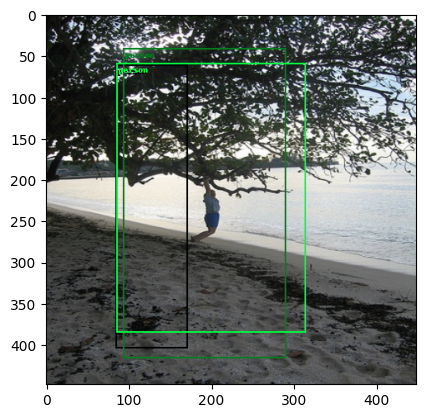

KeyboardInterrupt: 

In [8]:
run(0.05)